# Cell population simulation: wild type has growth advantage over mutant

Summary of code:
1) Define cell object to record 

    - self index
    - index of parent
    - birth time
    - plasmid count at birth
    - steady state plasmid count
    - division time (dependent on existence of plasmids) <p>&nbsp;</p>
    
2) Simulate population starting with "keep" number of cells at time 0 with a nonzero number of plasmids and uniformly distributed ages

    - Calculate steady state plasmid number. **Assume that plasmid distribution reaches steady state before division**. 
        + If initial plasmid count is 0, steady state plasmid count is 0
        + If initial plasmid count > 0, steady state plasmid count is sampled from the distribution Binom([max plasmid number n], 0.5)
            *Question: This means that a cell can lose plasmids entirely - should I choose a different distribution? <p>&nbsp;</p>
        
    - Partition plasmids to two daughter cells.
        + Number of plasmids in daughter 1: sample from Binom([steady state plasmid number], 0.5)
        + Number of plasmids in daughter 2: [steady state plasmid number]-[daughter 1 plasmid number] <p>&nbsp;</p>
    
    - Create two new daughter cells.
        + Birth times are the current cell's division time
        + Division time is [birth time] + a_m if they have 0 plasmids, and [birth time] + a_w if they have more than 0 plasmids <p>&nbsp;</p>

    - Remove current cell from queue of cells to process; add daughter cells. Sort the queue by division time so that the next cell to divide is processed in the next loop <p>&nbsp;</p>

3) I store all cells that have already divided in a list called "cells", and I store all cells in the queue, aka the currently alive population, in a list called "Q". 
    



In [1]:
import numpy as np
import random as rand
import matplotlib.pyplot as plt

In [25]:
class cell:
    def __init__(self,index,parent,birth,init_plasmid,tau):
        '''Initializes cell attributes
        param:: index: cell index
        param:: parent: index of parent cell
        param:: birth: birth time
        param:: init_plasmid: plasmids partitioned to cell at birth
        param:: tau: growth rate
        return:: None
        '''
        self.index=index
        self.parent = parent
        self.birth = birth
        self.init_plasmid = init_plasmid
        self.ss_plasmid = 100 #placeholder number; will calculate steady state plasmid number later
        self.div = birth+tau

In [143]:
def simulation(Nmax, keep, a_w, a_m, n, p):
    
    init_plasmid=1 #initial plasmid number of first cell. Arbitrary- just can't be 0
    #c= cell(0,[],0,init_plasmid,a_w)   #cell(index,parent,birth,initialplasmid,tau)
    
    Q=[] # initialize queue of cells that have not divided yet (currently alive cells)
    for i in range(keep):
        Q.append(cell(i, [], 0, init_plasmid, np.random.uniform(0,a_w))) #cell(index,parent,birth,initialplasmid,tau)
        #note: division time = birth + tau. 
        #I initialize cells so they will divide at some point between 0 and a_w time units in the future
        #so for the initialized cells, their age at the begining of the simulation is a_w - Q[i].div
   
    cells=[] #list of cells that have divided already
    N=keep-1 #indices taken by initialized cell population
    
    while len(cells)<Nmax:
        #sort Q so Q[0] is next cell to divide
        Q=sorted(Q,key=lambda x: x.div, reverse=False)
        
        #assign current cell to simulate
        current=Q[0]

        #Calculate steady state plasmid number
        if current.init_plasmid==0:
            ss_plasmid_num=0
        else:
            ss_plasmid_num=np.random.binomial(n,p,size=None)
        current.ss_plasmid=ss_plasmid_num

        #Partition plasmids between two daughter cells
        d1_plasmids=np.random.binomial(ss_plasmid_num,p,size=None)
        d2_plasmids=ss_plasmid_num-d1_plasmids

        #Create two new daughter cells
        if d1_plasmids==0:
            time=current.div
            break
            #daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter1=cell(N+1, current.index, current.div, d1_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
        if d2_plasmids==0:
            time=current.div
            break
            #daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_m) #index,parentindex,birth,initialplasmids,tau
        else:
            daughter2=cell(N+2, current.index, current.div, d2_plasmids, a_w) #index,parentindex,birth,initialplasmids,tau
    
        #Add current cell to vector 'cells'
        cells.extend([current])
    
        #####To keep cell population at a fixed number by removing one cell after each division
        ##### once the population reaches a certain size, include this section:
        
        if len(Q)>=keep:
            rem_cells = rand.sample(Q[1:],1)  #cells to be removed (does not include current or daughters)  
            new_Q = [x for x in Q if x not in rem_cells]
            Q = new_Q.copy()
        
        ########


        #Update index for next time
        N+=2

        #Update Q for next time - remove current cell, add daughter cells
        Q.remove(current)
        Q.extend([daughter1,daughter2])

        
    return Q, cells, time

In [174]:
Nmax=20000 #number of cells processed by simulation
keep=100
a_w=1 #wild type mean lifetime (note: the population with the shorter lifetime has the advantage)
a_m=2 #0 plasmid mean lifetime
n=20 #max number of plasmids
p=.5 #probability of success in binomial distribution; used to calculate steady state plasmid num and also 
     #daughter plasmid partitioning


[4.00897633560484, 0.6521454378948992, 0.4332401527524933, 3.244321529372872, 2.713083247019599, 3.1394658534357167, 7.437273521792586, 7.194499200880952, 1.6322255026331043, 5.025761142454484, 1.8400879056912958, 4.7434618686382795, 3.1680313532904507, 0.6190482856007931, 0.6778293937888259, 0.5035967091187045, 0.17232434384874518, 1.6363525614054364, 9.05728008237305, 6.013452679462228, 1.000362400959447, 8.095452311887138, 0.09491839814678338, 1.0334642573300057, 1.7174159131151203, 2.733340131341321, 2.081449193783181, 1.734537115737693, 1.5057832690462267, 2.1101257481696596, 2.4351839659297405, 0.30281800690597815, 2.0504764185073534, 4.044610196287917, 2.4801539789313214, 2.084139533674616, 0.6034060069590147, 0.5685701121276089, 1.1548543054679907, 1.4214386220479205, 3.211220329242787, 3.190631469655507, 2.8241618371825674, 1.1889212329289007, 3.079415606029866, 1.1324093668846316, 3.2643960185755363, 0.19384168263203816, 3.052123469096076, 2.1405298889137905, 5.60355702646097

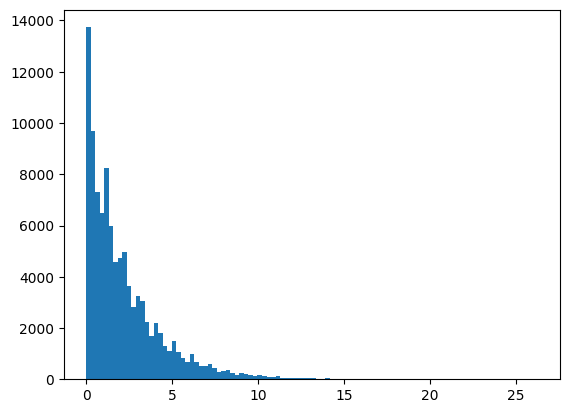

In [175]:
timevec=[]
for i in range(100000):
    Q, cells, time = simulation(Nmax, keep, a_w, a_m, n, p)
    timevec.extend([time])
plt.hist(timevec,100)
print(timevec)

(array([4730., 4334., 3728., 3401., 2979., 2740., 2641., 2320., 2144.,
        2029., 1800., 1700., 2359., 2897., 2560., 2291., 2109., 1893.,
        1732., 1595., 1504., 1330., 1291., 1158., 1104., 1994., 1741.,
        1550., 1414., 1277., 1176., 1023., 1016.,  975.,  826.,  789.,
         709.,  993., 1195., 1101.,  971.,  873.,  777.,  731.,  656.,
         617.,  587.,  518.,  469.,  461.,  795.,  699.,  637.,  578.,
         541.,  478.,  399.,  400.,  369.,  344.,  339.,  333.,  419.,
         478.,  467.,  393.,  353.,  323.,  284.,  279.,  265.,  212.,
         196.,  190.,  189.,  334.,  301.,  267.,  276.,  227.,  206.,
         183.,  172.,  165.,  136.,  131.,  125.,  193.,  223.,  188.,
         166.,  182.,  136.,  117.,  116.,   90.,   88.,   92.,   81.,
          68.]),
 array([0.  , 0.08, 0.16, 0.24, 0.32, 0.4 , 0.48, 0.56, 0.64, 0.72, 0.8 ,
        0.88, 0.96, 1.04, 1.12, 1.2 , 1.28, 1.36, 1.44, 1.52, 1.6 , 1.68,
        1.76, 1.84, 1.92, 2.  , 2.08, 2.16, 2.24, 2.32

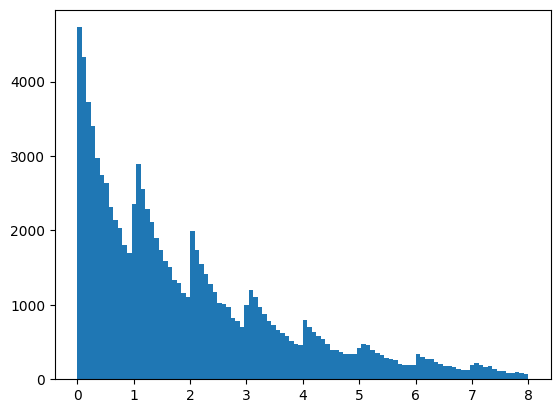

In [180]:
plt.hist(timevec,100,[0,8])


[0.16841122965150135, 0.42142909339485635, 2.301910697739566, 2.3825100920700253, 0.15906124575651936, 2.1566626742739095, 5.754272135562612, 0.7710207363126029, 0.2777426425029448, 0.8024367529531921, 0.1938245216640727, 6.454976935318731, 0.17072819029463904, 2.469250667777853, 0.39023711758285784, 1.286354443586502, 0.6111638149980241, 1.2520240274716021, 1.7296732281571943, 0.7252422380243596, 0.23279170094667734, 0.5222881603757683, 1.218080119449023, 1.27794698684601, 0.20072969913883032, 1.8524203727227484, 3.6214271389945476, 2.2500508126165646, 0.6090029885075652, 6.618399500022166, 3.2936771015108937, 0.3730471854865851, 1.4905679875309068, 0.4000692639157385, 0.0753713236517718, 1.395915055705246, 0.037885353168178204, 1.4651059898004468, 1.0750369874840056, 2.004285513561893, 0.7931298577709821, 1.0842666492770068, 3.4394217471372563, 3.799486776485069, 0.041832297044926525, 3.7849825808996767, 0.496161471490718, 0.1671846428327638, 1.9802021507297989, 2.6761256308295756, 0

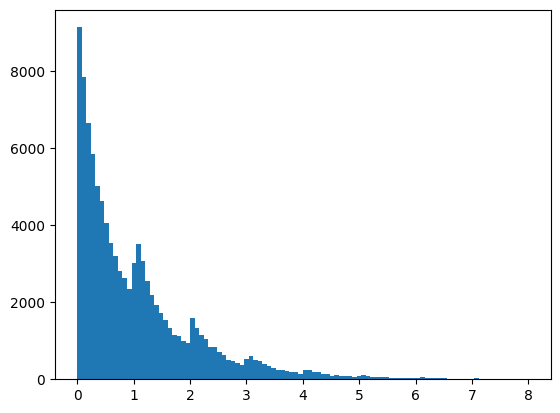

In [181]:
#with keep=200 instead of 100:
timevec=[]
for i in range(100000):
    Q, cells, time = simulation(Nmax, 200, a_w, a_m, n, p)
    timevec.extend([time])
plt.hist(timevec,100,[0,8])
print(timevec)

[0.4198391128698167, 0.019206496983512178, 0.27809050872886754, 0.3414132346657469, 0.42518958316153876, 0.43687079964223163, 1.395927164878046, 0.1584164312691101, 1.0499344104349309, 2.9468540535905534, 0.561238031008047, 0.7580516091149582, 0.8726809485616611, 1.4351180904448775, 0.15925007612918007, 0.014768348277409804, 0.11804162054513478, 0.5329661665048827, 0.1598649069496394, 1.4260299085694046, 1.7666846381412609, 0.5588903581406333, 0.09116602090504056, 0.03482243774442895, 1.6679008021057653, 0.15348091144206255, 0.6173973916740788, 0.7681495526682008, 0.0788752772395247, 0.8151422546993321, 0.1024957198253792, 0.2856816553583791, 0.2405176648536861, 0.7450151707482601, 2.703804203736291, 1.2041027299640072, 0.927077383014182, 0.11505574325521273, 1.1818900947981272, 0.1157277395407349, 1.0078731172671138, 1.0715567403090072, 0.24167355393930046, 0.2198710665192296, 0.039904948774538984, 0.023350290207238444, 1.6879792493315628, 0.01883193776649672, 0.0902892285770569, 1.47

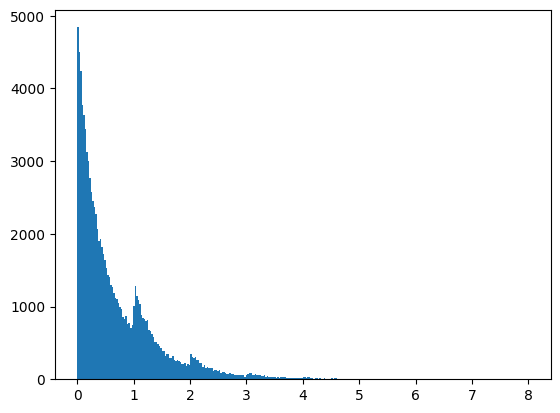

In [184]:
#with keep=300 instead of 100:
timevec=[]
for i in range(100000):
    Q, cells, time = simulation(Nmax, 300, a_w, a_m, n, p)
    timevec.extend([time])
plt.hist(timevec,300,[0,8])
print(timevec)

In [ ]:
for i in range(len(cells)):
    print(cells[i].div)

print(len(cells))
print(count)

In [ ]:
for i in range(len(Q)):
    print(Q[i].index)

print(len(Q))